In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [4]:
df = pd.read_csv('nyc1_fit.csv')

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Extraindo componentes da data
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.isocalendar().week

In [9]:
df.head()

,Unnamed: 0,item,department,units_sold,date,weekday,weekday_int,event,year,month,day,weekofyear
0,0,0,0,0,2015-01-01,4,6,1,2015,1,1,1
1,1,1,0,0,2015-01-01,4,6,1,2015,1,1,1
2,2,2,0,0,2015-01-01,4,6,1,2015,1,1,1
3,3,3,0,2,2015-01-01,4,6,1,2015,1,1,1
4,4,4,0,3,2015-01-01,4,6,1,2015,1,1,1


In [10]:
# Criando lag de 1 semana e 2 semanas
df['units_sold_lag_1'] = df.groupby('item')['units_sold'].shift(1)
df['units_sold_lag_2'] = df.groupby('item')['units_sold'].shift(2)

In [11]:
# Removendo as linhas com NaN criadas pelas lags
df = df.dropna()

In [12]:
df = df.drop(columns=['Unnamed: 0'])

In [13]:
df.head()

,item,department,units_sold,date,weekday,weekday_int,event,year,month,day,weekofyear,units_sold_lag_1,units_sold_lag_2
6098,0,0,0,2015-01-03,2,1,5,2015,1,3,1,0.0,0.0
6099,1,0,0,2015-01-03,2,1,5,2015,1,3,1,0.0,0.0
6100,2,0,0,2015-01-03,2,1,5,2015,1,3,1,1.0,0.0
6101,3,0,3,2015-01-03,2,1,5,2015,1,3,1,4.0,2.0
6102,4,0,1,2015-01-03,2,1,5,2015,1,3,1,0.0,3.0


In [14]:
# Separando variáveis independentes (X) e dependente (y)
X = df[['item', 'department', 'weekday', 'weekday_int', 'event',
        'year', 'month', 'day', 'weekofyear', 'units_sold_lag_1', 'units_sold_lag_2']]
y = df['units_sold']

In [15]:
# Divisão treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
import lightgbm as lgb
# Preparação dos datasets para o LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [21]:
# Treinamento
model = lgb.train(params,
                  train_data,
                  valid_sets=[train_data, validation_data],
                  num_boost_round=1000,
                  #early_stopping_rounds=50
                  )

In [22]:
# Previsão
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Avaliação
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 2.267928787052667


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

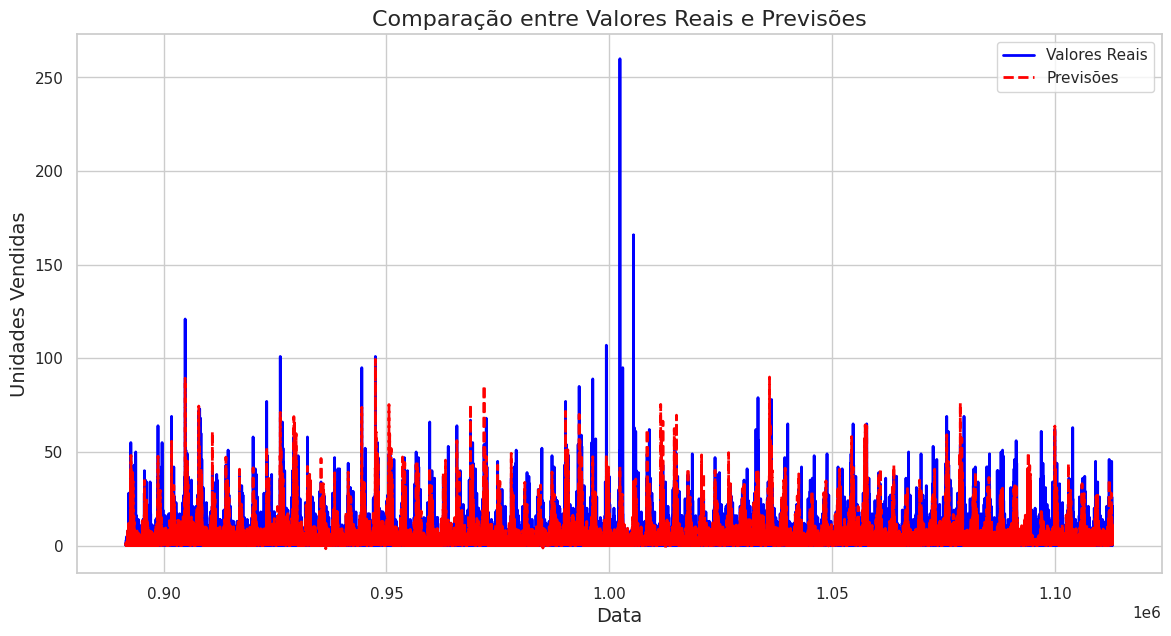

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plotando os valores reais
plt.plot(y_test.index, y_test, label='Valores Reais', color='blue', linewidth=2)

# Plotando as previsões
plt.plot(y_test.index, y_pred, label='Previsões', color='red', linestyle='--', linewidth=2)

# Adicionando título e legendas
plt.title('Comparação entre Valores Reais e Previsões', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Unidades Vendidas', fontsize=14)
plt.legend()

# Exibindo o gráfico
plt.show()
